In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from scipy.stats import spearmanr, ttest_1samp, binned_statistic
from settings import colors, titles, ax_label_size, tick_label_size, letter_size, legend_size, lw, line_alpha, fill_alpha

In [2]:
ccycle = mplego.colors.get_default_ccycle()

In [3]:
exp = 10
base_path = f"/storage/noise_correlations/exp{exp}"
loc = 'data'
loc = 'noise_correlations'

In [4]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_20_3000_1000.h5')
roi_path = os.path.join(f"/storage/{loc}/ret2/roi_positions.mat")

In [5]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

In [6]:
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)
n_results = len(results)

In [7]:
p_lower = 85
p_upper = 95
obs_percentile_lower = 25
obs_percentile_upper = 75
plot_lower = .875
plot_upper = .925

# FF and ND

In [8]:
with open(os.path.join(base_path, f'exp{exp}_ffs.pkl'), 'rb') as f:
    opt_r_ffs, opt_fa_ffs, obs_ffs = pickle.load(f)
    
with open(os.path.join(base_path, f'exp{exp}_cdfs.pkl'), 'rb') as f:
    all_null_equiv_cdfs, all_opt_fa_equiv_cdfs, all_opt_equiv_cdfs = pickle.load(f)

# Calculate correlations between max CDFs and percentiles
fa_ff_corrs = np.zeros((len(results), dims.size))
fa_nd_corrs = np.zeros((len(results), dims.size))

for result_idx, result in enumerate(results):
    for dim_idx, dim in enumerate(dims):
        fa_ff_corrs[result_idx, dim_idx] = spearmanr(
            result['p_fa_lfi'][dim_idx],
            np.log(opt_fa_ffs[result_idx][dim_idx]) - np.log(obs_ffs[result_idx][dim_idx]),
        ).correlation
        fa_nd_corrs[result_idx, dim_idx] = spearmanr(
            result['p_fa_lfi'][dim_idx],
            np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1) - np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1),
        ).correlation

dim_idx = 0
dim = dim_idx + 3
# Maximum values
max_null_cdfs = [np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1)
                 for result_idx in range(n_results)]
max_opt_fa_cdfs = [np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1)
                   for result_idx in range(n_results)]

In [9]:
fa_cdf_mse = []
fa_cdf_rank = []
fa_ff_mse = []
fa_ff_rank = []
avg_rank = []
best_obs_p_rank = np.zeros((3, 18, 3))

for result_idx, result in enumerate(results):
    fa_ff_mse.append((opt_fa_ffs[result_idx] - obs_ffs[result_idx])**2)
    fa_ff_rank.append(np.argsort(fa_ff_mse[-1], axis=-1))
    ff_mse_temp = np.zeros_like(fa_ff_mse[-1])
    for dim_idx, dim in enumerate(dims):
        fa_max = np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1)
        equiv_max = np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1)
        ff_mse_temp[dim_idx] = (fa_max - equiv_max)**2
    fa_cdf_mse.append(ff_mse_temp)
    fa_cdf_rank.append(np.argsort(fa_cdf_mse[-1], axis=-1))
    avg_rank.append(-0.5 * (fa_ff_rank[-1] + fa_cdf_rank[-1]))
    
    # Grab observed percentiles for best avg ranks
    best_obs_p_temp = np.zeros_like(fa_ff_mse[-1])
    for dim_idx, dim in enumerate(dims):
        avg_rank_temp = avg_rank[-1][dim_idx]
        rank_lower, rank_upper = np.percentile(avg_rank_temp, q=[p_lower, p_upper])
        p_fa_lfi_slice = result['p_fa_lfi'][dim_idx][(avg_rank_temp > rank_lower) & (avg_rank_temp <= rank_upper)]
        best_obs_p_rank[result_idx, dim_idx] = np.percentile(p_fa_lfi_slice, q=[obs_percentile_lower, 50, obs_percentile_upper])

# Activity

In [10]:
# RET2
ret2_data_path = f'/storage/{loc}/ret2/200114_fov1_data.mat'
ret2_pack = packs.RET2(data_path=ret2_data_path)
X_ret2 = ret2_pack.get_response_matrix(cells='tuned', response='max')
# PVC11 - 1
pvc11_1_data_path = f'/storage/{loc}/pvc11/data/spikes_gratings/data_monkey1_gratings.mat'
pvc11_1_pack = packs.PVC11(data_path=pvc11_1_data_path)
X_pvc11 = pvc11_1_pack.get_response_matrix(transform=None)
# ECOG
ecog_data_path = f'/storage/{loc}/ecog/r32_b7.mat'
ecog_pack = packs.ECOG(data_path=ecog_data_path)
X_ecog = ecog_pack.get_response_matrix(bounds=[40, 60], band='HG', electrodes=ecog_pack.pac_idxs)

In [11]:
mu_ret2 = np.zeros((ret2_pack.n_angles, X_ret2.shape[1]))
mu_pvc11 = np.zeros((pvc11_1_pack.n_stimuli, X_pvc11.shape[1]))
mu_ecog = np.zeros((ecog_pack.freq_set.size, X_ecog.shape[1]))

for idx, angle in enumerate(ret2_pack.unique_angles):
    mu_ret2[idx] = X_ret2[ret2_pack.angles == angle].mean(axis=0)

for idx, angle in enumerate(pvc11_1_pack.get_angles()):
    mu_pvc11[idx] = X_pvc11[pvc11_1_pack.get_design_matrix() == angle].mean(axis=0)
    
for idx, frequency in enumerate(ecog_pack.freq_set):
    mu_ecog[idx] = X_ecog[ecog_pack.get_design_matrix('frequency') == frequency].mean(axis=0)

rank_ret2 = -np.argsort(mu_ret2, axis=0)
rank_pvc11 = -np.argsort(mu_pvc11, axis=0)
rank_ecog = -np.argsort(mu_ecog, axis=0)
ranks = [rank_ret2, rank_pvc11, rank_ecog]

In [12]:
avg_tuning_ranks = []
best_tuning_p_rank_fa = np.zeros((3, 18, 3))
best_tuning_p_rank_u = np.zeros((3, 18, 3))

for result_idx, (result, rank) in enumerate(zip(results, ranks)):
    n_dimstims = result['p_r_lfi'].shape[1]
    avg_tuning_ranks_temp = np.zeros((dims.size, n_dimstims))
    unique_stimuli = np.unique(result['stimuli'][:])

    for dim_idx, dim in enumerate(dims):
        for dimstim_idx in range(n_dimstims):
            units = result['units'][dim_idx, dimstim_idx][:dim]
            stims = result['stims'][dim_idx, dimstim_idx]
            rank1 = np.mean(rank[unique_stimuli == stims[0]][:, units])
            rank2 = np.mean(rank[unique_stimuli == stims[1]][:, units])
            total_rank = 0.5 * (rank1 + rank2)
            avg_tuning_ranks_temp[dim_idx, dimstim_idx] = total_rank
    avg_tuning_ranks.append(avg_tuning_ranks_temp)
    
    for dim_idx, dim in enumerate(dims):
        avg_rank_temp = avg_tuning_ranks[-1][dim_idx]
        rank_lower, rank_upper = np.percentile(avg_rank_temp, q=[p_lower, p_upper])
        p_fa_lfi_slice = result['p_fa_lfi'][dim_idx][(avg_rank_temp > rank_lower) & (avg_rank_temp <= rank_upper)]
        p_u_lfi_slice = result['p_u_lfi'][dim_idx][(avg_rank_temp > rank_lower) & (avg_rank_temp <= rank_upper)]
        best_tuning_p_rank_fa[result_idx, dim_idx] = np.percentile(p_fa_lfi_slice, q=[obs_percentile_lower, 50, obs_percentile_upper])
        best_tuning_p_rank_u[result_idx, dim_idx] = np.percentile(p_u_lfi_slice, q=[obs_percentile_lower, 50, obs_percentile_upper])

# Positions

In [13]:
with h5py.File(roi_path, 'r') as f:
    positions = f['xyPosDS'][:]
distances = np.linalg.norm(positions[:, :, np.newaxis] - positions[:, np.newaxis, :], axis=0)

In [14]:
n_ret2_dimlets = 1000
n_ret2_dimstims = 6 * n_ret2_dimlets
dimlet_distances = np.zeros((dims.size, n_ret2_dimstims))

units = ret2['units'][:]
for dim_idx, dim in enumerate(dims):
    for dimlet_idx in range(n_ret2_dimstims):
        unit_temp = units[dim_idx, dimlet_idx, :dim]
        tri_idx = np.triu_indices(dim, k=1)
        mean_dist = np.mean(distances[unit_temp][:, unit_temp][tri_idx])
        dimlet_distances[dim_idx, dimlet_idx] = mean_dist

rank_distances = -np.argsort(dimlet_distances, axis=1)

In [15]:
best_position_p_rank_fa = np.zeros((3, 18, 3))
best_position_p_rank_u = np.zeros((3, 18, 3))

for dim_idx, dim in enumerate(dims):
    rank_temp = rank_distances[dim_idx]
    rank_lower, rank_upper = np.percentile(rank_temp, q=[p_lower, p_upper])
    p_fa_lfi_slice = ret2['p_fa_lfi'][dim_idx][(rank_temp > rank_lower) & (rank_temp <= rank_upper)]
    p_u_lfi_slice = ret2['p_u_lfi'][dim_idx][(rank_temp > rank_lower) & (rank_temp <= rank_upper)]
    best_position_p_rank_fa[result_idx, dim_idx] = np.percentile(p_fa_lfi_slice, q=[obs_percentile_lower, 50, obs_percentile_upper])
    best_position_p_rank_u[result_idx, dim_idx] = np.percentile(p_u_lfi_slice, q=[obs_percentile_lower, 50, obs_percentile_upper])

Ttest_1sampResult(statistic=-26.06070727614478, pvalue=3.809929073289782e-15) Ttest_1sampResult(statistic=-38.18545349768293, pvalue=6.402427335631706e-18)
Ttest_1sampResult(statistic=-22.861583879211747, pvalue=3.329591733708091e-14) Ttest_1sampResult(statistic=-20.956971239741133, pvalue=1.3923154786234983e-13)
Ttest_1sampResult(statistic=-17.368285249250032, pvalue=2.9615587821829257e-12) Ttest_1sampResult(statistic=-15.104865864492787, pvalue=2.7719729246680278e-11)


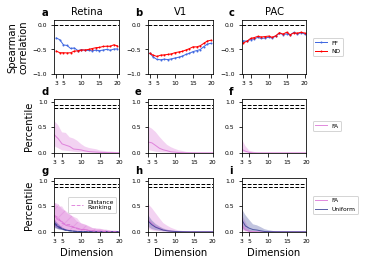

In [17]:
"""
Figure Settings
"""
# Font sizes
title_pad = 5

model_labels = ['Observed', 'FA']
label_dict = {'observed': model_labels[0], 'fa': model_labels[1]}
bins = [
    np.linspace(-1.5, -0.75, 30),
    np.linspace(0, 1.2, 30),
    np.linspace(0, 1.5, 30)
]
labels = [
    'Uniform',
    'FA'
]
percentile_groups = [
    'p_u_lfi',
    'p_fa_lfi'
]
models = [
    'uniform',
    'fa'
]

"""
Figure 6
"""
figsize = (5, 3.5)
fig = plt.figure(figsize=figsize)
le = .15
re = .15
te = .06
be = .1
h = .15
hg = .08
vg = .1
w = (1. - le - re - 2.*hg) / 3.
h = (1. - te - be - 2*vg) / 3.

axes = np.empty((3, 3), dtype=object)
for ii in range(3):
    for jj in range(3):
        axes[ii, jj] = fig.add_axes([le + jj*(w + hg), be + (2 - ii)*(h + vg), w, h])


for idx, result in enumerate(results):
    # Top Row    
    axes[0, idx].plot(
        dims,
        fa_ff_corrs[idx],
        color='royalblue',
        marker='.',
        lw=lw,
        markersize=2, label='FF')
    axes[0, idx].plot(
        dims,
        fa_nd_corrs[idx],
        color='r',
        marker='.',
        lw=lw,
        markersize=2, label='ND')
    print(ttest_1samp(fa_ff_corrs[idx], 0.), ttest_1samp(fa_nd_corrs[idx], 0.))

    # Average rank over dimensions
    axes[1, idx].plot(
        dims,
        best_obs_p_rank[idx, :, 1],
        linewidth=lw,
        alpha=line_alpha,
        color=colors['fa'],
        label=labels[1])

    axes[1, idx].fill_between(
        x=dims,
        y1=best_obs_p_rank[idx, :, 0],
        y2=best_obs_p_rank[idx, :, 2],
        color=colors['fa'],
        alpha=fill_alpha,
        ec='none')
    axes[1, idx].axhline(plot_lower, linestyle='--', color='k', lw=lw)
    axes[1, idx].axhline(plot_upper, linestyle='--', color='k', lw=lw)

    # Average rank over dimensions
    axes[2, idx].plot(
        dims,
        best_tuning_p_rank_fa[idx, :, 1],
        linewidth=lw,
        alpha=line_alpha,
        color=colors['fa'],
        label=labels[1] if idx ==2 else None)

    axes[2, idx].fill_between(
        x=dims,
        y1=best_tuning_p_rank_fa[idx, :, 0],
        y2=best_tuning_p_rank_fa[idx, :, 2],
        color=colors['fa'],
        alpha=fill_alpha,
        ec='none')

    # Average rank over dimensions
    axes[2, idx].plot(
        dims,
        best_tuning_p_rank_u[idx, :, 1],
        linewidth=lw,
        alpha=line_alpha,
        color=colors['uniform'],
        label=labels[0] if idx ==2 else None)

    axes[2, idx].fill_between(
        x=dims,
        y1=best_tuning_p_rank_u[idx, :, 0],
        y2=best_tuning_p_rank_u[idx, :, 2],
        color=colors['uniform'],
        alpha=fill_alpha,
        ec='none')

    axes[2, idx].axhline(plot_lower, linestyle='--', color='k', lw=lw)
    axes[2, idx].axhline(plot_upper, linestyle='--', color='k', lw=lw)

    
axes[2, 0].plot(
    dims,
    best_position_p_rank_u[idx, :, 1],
    linewidth=lw,
    linestyle='--',
    alpha=line_alpha,
    color=colors['uniform'])

axes[2, 0].fill_between(
    x=dims,
    y1=best_position_p_rank_u[idx, :, 0],
    y2=best_position_p_rank_u[idx, :, 2],
    color=colors['uniform'],
    hatch='//',
    alpha=fill_alpha,
    ec='none')

axes[2, 0].plot(
    dims,
    best_position_p_rank_fa[idx, :, 1],
    linewidth=lw,
    linestyle='--',
    alpha=line_alpha,
    label='Distance\nRanking',
    color=colors['fa'])

axes[2, 0].fill_between(
    x=dims,
    y1=best_position_p_rank_fa[idx, :, 0],
    y2=best_position_p_rank_fa[idx, :, 2],
    color=colors['fa'],
    hatch='//',
    alpha=fill_alpha,
    ec='none')
axes[2, 0].legend(loc='best', prop={'size': legend_size})
axes[2, 2].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    prop={'size': legend_size})


for ax in axes.ravel():
    ax.set_xlim([2.5, max(dims) + 0.5])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.tick_params(labelsize=tick_label_size)
    
# Top row settings
for ax in axes[0]:
    ax.set_xlim([2.5, max(dims) + 0.5])
    ax.set_ylim([-1, 0.1])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([-1, -0.5, 0])
    ax.axhline(0, color='k', linestyle='--', lw=lw)
axes[0, 0].set_ylabel('Spearman\ncorrelation', fontsize=ax_label_size)
axes[0, 2].legend(loc='center left', fontsize=legend_size, bbox_to_anchor=(1.05, 0.5))
# Apply titles
axes[0, 0].set_title(r'Retina', fontsize=ax_label_size, pad=title_pad)
axes[0, 1].set_title(r'V1', fontsize=ax_label_size, pad=title_pad)
axes[0, 2].set_title(r'PAC', fontsize=ax_label_size, pad=title_pad)

axes[1, 2].legend(loc='center left', fontsize=legend_size, bbox_to_anchor=(1.05, 0.5))

for idx, ax in enumerate(axes[1:].ravel()):
    ax.set_xlim([3, 20])
    ax.set_ylim([0, 1.05])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([0, .5, 1])
    ax.tick_params(labelsize=tick_label_size)
for ax in axes[2]:
    ax.set_xlabel('Dimension', fontsize=ax_label_size)
for ax in axes[1:, 0]:
    ax.set_ylabel('Percentile', fontsize=ax_label_size)

# Apply subplot labels
lets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
c = 0
for ii in range(3):
    for jj in range(3):
        ax = axes[ii, jj]
        ax.text(-.2, 1.07, lets[c], size=letter_size, fontweight='bold',
                transform=ax.transAxes)
        c += 1
# for ax in caxes:
#     ax.tick_params(labelsize=tick_label_size)

plt.savefig('supp4.pdf', dpi=300)
plt.savefig('supp4.jpg', dpi=300)
plt.show()